In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.linalg import SparseVector, DenseVector
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

from math import floor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

#Instantiate the spark session
spark = SparkSession.builder.appName("GBat_model_FE").getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", 8)

In [2]:
#split each group and return first 80% cycles 
def train_split(grp):
    grp = grp.sort_values(by=['cycle'])
    idx = floor(0.80*grp.shape[0])
    return  grp.iloc[:idx]

#split each group and return rest 20% cycles
def test_split(grp):
    grp = grp.sort_values(by=['cycle'])
    idx = floor(0.80*grp.shape[0])
    return grp.iloc[idx:]

In [3]:
#sMAPE
def sMAPE(y_true, y_pred):
  denominator = (np.abs(y_true) + np.abs(y_pred))
  diff = np.abs(y_true - y_pred) / denominator
  diff[denominator == 0] = 0.0
  sma =200 * np.mean(diff)
  return sma
  
#define function to generate graphs for each cell-protocol combination seperately
def plot_groups(grouped, x, y_true, y_pred):
    
    key_list = list(grouped.groups.keys())
    
    fig, axs = plt.subplots( figsize = (12, 220), dpi= 100, nrows= len(key_list), ncols= 1) 

    targets = zip(key_list, axs.flatten())
        
    for i, (key, ax) in enumerate(targets):
        grp = grouped.get_group(key)
        ax.plot(grp.loc[grp['split'] == 'train', x], grp.loc[grp['split'] == 'train', y_true], label='train: true',
                color='black', marker='.', linestyle='solid' )
        ax.plot(grp.loc[grp['split'] == 'train', x], grp.loc[grp['split'] == 'train', y_pred], label='train: pred',
               color='green', marker='.', linestyle='dashed')
        ax.plot(grp.loc[grp['split'] == 'test', x], grp.loc[grp['split'] == 'test', y_true], label='test: true',
               color='blue', marker='.', linestyle='solid' )
        ax.plot(grp.loc[grp['split'] == 'test', x], grp.loc[grp['split'] == 'test', y_pred], label='test: pred',
               color='magenta', marker='.', linestyle='dashed' )

        ax.set_title("#{}: cell = {} protocol = {}".format(i+1, key_list[i][0], key_list[i][1]) )
        ax.set_xlabel('cycle')
        ax.set_ylabel(y_true)
        ax.legend()
        
    plt.show()

In [4]:
def model_performance_with_plots(trainDF, testDF, labelCol, featuresCol='features', regParam= 0):
  #regParam= (0.8326/(2*8288)),
  RR = LinearRegression(featuresCol=featuresCol, labelCol=labelCol, predictionCol='prediction', regParam=regParam , maxIter=1000, elasticNetParam=0, tol=1e-11, fitIntercept=True, standardization=False, solver='normal', loss='squaredError')
  
  #Train the model on the training using fit() method.
  model = RR.fit(trainDF)

  #Predict on Test Dataset using the evulate method
  test_df_with_pred = model.evaluate(testDF)
  
  #Predict on Train Dataset using the evulate method
  train_df_with_pred = model.evaluate(trainDF)

  #Find out coefficient value
  coefficient = model.coefficients

  #Find out intercept Value
  intercept = model.intercept
  
  #convert to pandas for plotting
  test_df_pd = test_df_with_pred.predictions.toPandas()
  train_df_pd = train_df_with_pred.predictions.toPandas()
  
  #Evaluate the model using metric like Mean Absolute Error(MAE), Root Mean Square Error(RMSE) and R-Square
  evaluation = RegressionEvaluator(labelCol=labelCol, predictionCol="prediction")

  # r2 - coefficient of determination
  r2 = evaluation.evaluate(test_df_with_pred.predictions, {evaluation.metricName: "r2"})

  #RMSE
  rmse = evaluation.evaluate(test_df_with_pred.predictions, {evaluation.metricName: "rmse"})

  #sMape result
  smape = sMAPE(test_df_pd[labelCol], test_df_pd.prediction)
  
  #add column to identify test and train data while plotting before joining the dfs'.
  test_df_pd['split'] = 'test'
  train_df_pd['split'] = 'train'

  #join the dfs' with predicted values for plotting
  final_df_pd = pd.concat([train_df_pd, test_df_pd]).sort_values(by=['cell_no', 'protocol', 'cycle']).reset_index(drop = True)
  
  grouped = final_df_pd.groupby(['cell_no', 'protocol'])
  plot_groups(grouped, 'cycle', labelCol, 'prediction')
  
  return final_df_pd, coefficient, intercept, r2, rmse, smape

##model performance for di with engineered features

In [6]:
#read csv file with aggregated data with engineered features
di_FE_cyc_agg_DF = spark.read.csv("/FileStore/tables/di_FE_cyc_agg_DF.csv", inferSchema = True, header = True).cache()

#materialize the DF in memory
di_FE_cyc_agg_DF.count()

Out[5]: 8288

In [7]:
display(di_FE_cyc_agg_DF.limit(10))

cell_no protocol cycle di dur_by_ocv cell_3 cell_4 cell_5 cell_6 cell_7 cell_9 cell_10 cell_11 cell_13 cell_14 cell_18 cell_19 cell_20 cell_23 cell_24 cell_26 cell_27 cell_28 cell_29 T_b6 i0x2a i0x8c c_const_B_14 c_const_B_6b cycle*sin(i0x91) T_5a**3*cycle**2 i0x28**3*sin(i0x2a) cycle**2*sqrt(i0x94) i0x8c**2*(1 - i0x8c) sqrt(i0xb1)*(1 - i0xb1) c_const_B_b2*cos(i0x28) c_const_T_c4**3*i0x91**3 cycle**2*exp(c_const_T_32) i0x2 T_5a i0x73 i0xb1 i0x83 i0x91 i0x8a rng_ocv i0x8c**2*(1 - T_5a) i0x28**3*sin(i0x8a) (1 - i0x28)*sin(i0x28) sqrt(i0x91)*(1 - i0x91) c_const_B_b2*rng_ocv**2 sqrt(i0xa7)*exp(c_const_T_5) sqrt(i0xa7)*cos(c_const_T_32) i0x6 i0x28 c_const_T_c4 B_78**3*(1 - i0x28) c_const_T_32**2*i0x2a max_ocv min_ocv c_const_T_32 c_const_B_76 cycle*i0x2a**2 2**B_78*exp(T_5a) exp(i0x2a)*exp(-i0xa7) 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 4 0.8581709671757066 2.5835794172259505 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.75 0.8998330550918195 0.5216049382716047 0.0 1.0 1.6848529829964756 0.0 0.4828051582207358 0.0 0.13015776327946088 0.3749412917110145 0.6591835380995953 0.0 26.37954033120205 0.59993332222037 0.0 0.0 0.2497655517349173 0.6533333333333337 0.4347826086956523 0.25306122448979607 894.0 0.27207171162932453 0.15433580849478237 0.11199733249553011 0.3726933110497926 799236.0 0.29111125486979095 0.2554741608437524 1.0 0.8510638297872338 0.0 0.14893617021276617 0.2249582637729549 4223.0 3329.0 0.5 0.0 3.23879810814351 2.0 2.259372889778542 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 5 0.8378322686997732 2.456929292929293 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.75 0.8824127168469186 0.5301932367149756 0.0 1.0 2.1060662287455942 0.0 0.4760556867096762 3.195580893319489 0.13206496830009615 0.3749412917110145 0.6591835380995952 0.0 41.218031767503206 0.5999333222203699 0.0 0.01960784313725489 0.2497655517349173 0.6556521739130435 0.4347826086956523 0.253061224489796 792.0 0.2811048682583022 0.15433580849478246 0.11199733249552998 0.3726933110497926 627264.0 0.291111254869791 0.25547416084375246 1.0 0.851063829787234 0.0 0.14893617021276595 0.22060317921172964 4231.0 3439.0 0.5 0.0 3.8932610142658004 2.0 2.220354691648627 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 6 0.6952971199416699 2.940632958801498 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.75 0.37434185180428825 0.7594017094017089 0.0 1.0 2.5272794744947134 0.0 0.22540518406329269 1.972129922734312 0.13875085827537623 0.3749412917110145 0.6591835380995947 0.0 59.35396574520462 0.5999333222203703 0.0 0.0036014405762304917 0.24976555173491727 0.7175384615384616 0.4347826086956523 0.09218210361067482 801.0 0.5766909562422375 0.056743715313260126 0.11199733249552961 0.3726933110497926 641601.0 0.2911112548697907 0.2554741608437522 1.0 0.8510638297872346 0.0 0.1489361702127654 0.09358546295107206 4221.0 3420.0 0.5 0.0 0.8407909320735822 2.0 1.3358877993862757 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 7 0.6931638661496483 2.945014963840399 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.75 0.36915060454292414 0.7617845117845112 0.0 1.0 2.9484927202438325 0.0 0.22242370927475177 3.900179970368944 0.13824017407215422 0.3749412917110145 0.6591835380995947 0.0 80.78734226430628 0.5999333222203704 0.0 0.007603041216486587 0.24976555173491727 0.7181818181818181 0.4347826086956523 0.0908472479901049 802.0 0.5803156423947662 0.055924308588037715 0.11199733249552961 0.3726933110497926 643204.0 0.2911112548697907 0.2554741608437522 1.0 0.8510638297872346 0.0 0.1489361702127654 0.09228765113573104 4221.0 3419.0 0.5 0.0 0.9539051818408446 2.0 1.3289708448506383 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 8 0.7021447505823759 2.903154135338346 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.75 0.409184799524630

In [8]:
#split the data into train and test
myschema = di_FE_cyc_agg_DF.schema

di_train_DF = di_FE_cyc_agg_DF.select("*") \
  .groupBy("cell_no","protocol") \
  .applyInPandas(train_split, schema = myschema) \
  .orderBy("cell_no", "protocol", "cycle") \
  .cache()
  
di_test_DF = di_FE_cyc_agg_DF.select("*") \
  .groupBy("cell_no","protocol") \
  .applyInPandas(test_split, schema = myschema) \
  .orderBy("cell_no", "protocol", "cycle") \
  .cache()

print(di_train_DF.count())
print(di_test_DF.count())

6608
1680

In [9]:
#columns which are not features
drop_cols = ['cell_no', 'protocol', 'di', 'dur_by_ocv', 'charge_duration']

#create feature vectors
vectAssembler = VectorAssembler(inputCols= [col for col in di_FE_cyc_agg_DF.columns if col not in drop_cols], outputCol="features")
di_train_DF_feat_vect = vectAssembler.transform(di_train_DF)
di_test_DF__feat_vect = vectAssembler.transform(di_test_DF)

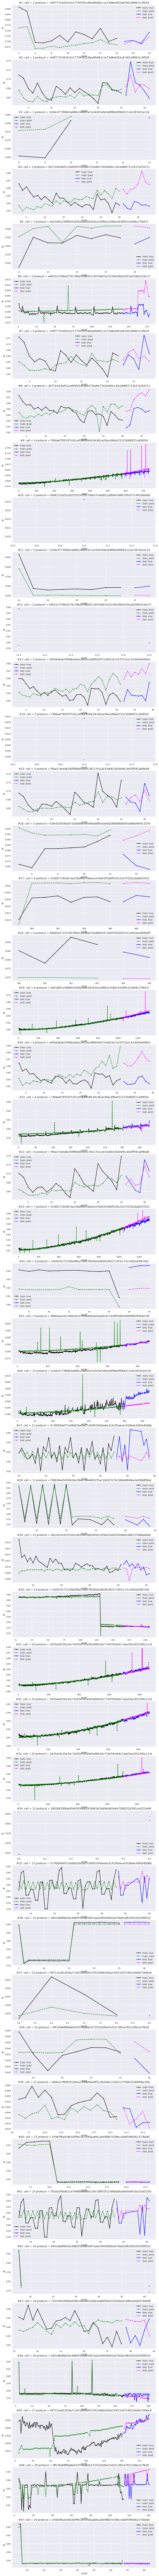

In [10]:
di_final_df_pd, coefficient, intercept, r2, rmse, smape =  model_performance_with_plots(trainDF = di_train_DF_feat_vect , testDF = di_test_DF__feat_vect , labelCol = 'di', featuresCol='features', regParam= (0.8326/(2*8288)))

In [11]:
print ("The coefficients of the model are : %a" %coefficient, '\n')
print ("The Intercept of the model is : %f" %intercept, '\n')
print("r2: %.3f" %r2, '\n')
print("RMSE: %.3f" %rmse, '\n')
print('sMAPE: %f' %smape, '\n' )

The coefficients of the model are : DenseVector([-0.0, -0.0035, 0.001, 0.0, -0.0013, -0.0037, -0.0179, -0.0044, -0.0003, 0.0023, 0.0132, -0.0027, -0.0038, -0.0018, 0.0015, -0.0011, 0.0016, -0.0033, -0.0159, 0.0013, 0.0032, 0.035, 0.0103, -0.0072, 0.0001, 0.0, -0.0, 0.024, 0.0, 0.0023, 0.0059, -0.0094, 0.002, 0.0, 0.0036, -0.011, -0.0082, 0.0077, 0.0002, 0.0071, 0.0069, 0.0, 0.0228, 0.0062, -0.0157, 0.005, -0.0, -0.0002, 0.0004, 0.0045, 0.0207, 0.0019, -0.0207, 0.0087, 0.0, -0.0, 0.0109, 0.0021, 0.0132, -0.0131, 0.048]) 

The Intercept of the model is : 0.590641 

r2: 0.898 

RMSE: 0.010 

sMAPE: 0.742710

##model performance for dur_by_ocv with engineered features

In [13]:
#read csv file with aggregated data with engineered features
dur_by_ocv_FE_cyc_agg_DF = spark.read.csv("/FileStore/tables/dur_by_ocv_FE_cyc_agg_DF.csv", inferSchema = True, header = True).cache()

#materialize the DF in memory
dur_by_ocv_FE_cyc_agg_DF.count()

Out[11]: 8288

In [14]:
display(dur_by_ocv_FE_cyc_agg_DF.limit(10))

cell_no protocol cycle di dur_by_ocv cell_3 cell_4 cell_5 cell_6 cell_7 cell_9 cell_10 cell_11 cell_13 cell_14 cell_18 cell_19 cell_20 cell_23 cell_24 cell_26 cell_27 cell_28 cell_29 i0x6 i0xb1 i0x83 i0x2a i0x28 i0x91 i0x8c max_ocv rng_ocv P_const_2c c_const_B_9 c_const_T_32 c_const_B_b2 P_const_2c/cycle c_const_B_6b*cycle min_ocv**3*rng_ocv (1 - i0xcd)/rng_ocv i0x2a**2*sin(i0xcd) cycle**3*sin(i0xcd) sqrt(i0x8a)/rng_ocv i0xa7**3*(1 - i0x28) min_ocv**3*cos(i0xa7) rng_ocv**3*sin(i0xb1) (1 - i0x8c)*exp(-B_78) (1 - i0x28)*sin(i0x28) P_const_2c*c_const_B_3b sqrt(i0x91)*(1 - i0x91) P_const_30*cos(max_ocv) sqrt(i0xb1)*(1 - i0xb1) c_const_B_c9*(1 - i0x28) c_const_B_29*cos(max_ocv) sqrt(i0xcd)*sin(c_const_T_5) exp(c_const_T_c4)*sin(i0x91) rng_ocv**3*exp(-c_const_T_32) i0x8a i0x94 i0x28**3*sin(i0x8a) sqrt(i0x8a)*exp(i0x94) c_const_B_6b*sqrt(c_const_T_5) c_const_B_76*exp(-c_const_T_c4) log(rng_ocv)/rng_ocv c_const_T_32**2/cycle c_const_B_9*sqrt(i0x91) c_const_B_6b*rng_ocv**3 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 4 0.8581709671757066 2.5835794172259505 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.2497655517349173 0.6533333333333337 0.8998330550918195 0.8510638297872338 0.4347826086956523 0.5216049382716047 4223.0 894.0 0.0 0.0 0.5 1.0 0.0 4.0 3.2982145578366E13 0.0011185682326621924 0.0 0.0 5.626978862786517E-4 9.064715125010713E-5 3.676038045517419E10 1.766120163782898E8 0.1759917079678197 0.11199733249553011 0.0 0.3726933110497926 0.0 0.3749412917110145 0.14893617021276617 0.7651812133823827 0.0 0.4212132457491189 4.3337645768140113E8 0.25306122448979607 0.0 0.15433580849478237 0.5030519103331147 0.0 0.0 0.0076014605986280915 0.0625 0.0 7.14516984E8 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 5 0.8378322686997732 2.456929292929293 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.2497655517349173 0.6556521739130435 0.8824127168469186 0.851063829787234 0.4347826086956523 0.5301932367149756 4231.0 792.0 0.0 0.0 0.5 1.0 0.0 5.0 3.2212298067048E13 0.0012316764442827474 0.01908461093006376 3.0637251875955296 6.351665534509023E-4 9.064715125010707E-5 4.052613058584397E10 1.2279572208808006E8 0.17283224953585885 0.11199733249552998 0.0 0.3726933110497926 -0.0 0.3749412917110145 0.14893617021276595 -0.7482975385137427 0.0 0.4212132457491189 3.0132023940531635E8 0.253061224489796 0.016338779593197735 0.15433580849478246 0.5113386781068988 0.0 0.0 0.008427476504816194 0.05 0.0 4.96793088E8 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 6 0.6952971199416699 2.940632958801498 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.24976555173491727 0.7175384615384616 0.37434185180428825 0.8510638297872346 0.4347826086956523 0.7594017094017089 4221.0 801.0 0.0 0.0 0.5 1.0 0.0 6.0 3.2041352088E13 0.0012428186627645907 6.30906521936419E-4 0.9724829576992173 3.790450165716833E-4 9.06471512501063E-5 3.985813100043358E10 1.270296907352198E8 0.08851116469210361 0.11199733249552961 0.0 0.3726933110497926 0.0 0.3749412917110145 0.1489361702127654 0.2669915507715294 0.0 0.4212132457491189 3.117096929196305E8 0.09218210361067482 0.0030010003334444784 0.056743715313260126 0.3045275757127618 0.0 0.0 0.008346892568125293 0.041666666666666664 0.0 5.13922401E8 1 140f77741820c02177597651dfea9fe881c1a73d8e4002a87d0148967cc0f029 7 0.6931638661496483 2.945014963840399 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.24976555173491727 0.7181818181818181 0.36915060454292414 0.8510638297872346 0.4347826086956523 0.7617845117845112 4221.0 802.0 0.0 0.0 0.5 1.0 0.0 7.0 3.2053220465318E13 0.0012350314808276957 0.0012952137186617722 3.260080978389919 3.7582141178480583E-4 9.06471512501063E-5 3.982317794980895E10 1.2750605158019638E8 0.08763458068309632 0.11199733249552961 0.0 0.3726933110497926 0.0 0.3749412917110145 0.1489361702127654 0.2669915507715294 0.0 0.4212132457491189 3

In [15]:
#split the data into train and test
myschema = dur_by_ocv_FE_cyc_agg_DF.schema

dur_by_ocv_train_DF = dur_by_ocv_FE_cyc_agg_DF.select("*") \
  .groupBy("cell_no","protocol") \
  .applyInPandas(train_split, schema = myschema) \
  .orderBy("cell_no", "protocol", "cycle") \
  .cache()
  
dur_by_ocv_test_DF = dur_by_ocv_FE_cyc_agg_DF.select("*") \
  .groupBy("cell_no","protocol") \
  .applyInPandas(test_split, schema = myschema) \
  .orderBy("cell_no", "protocol", "cycle") \
  .cache()

print(dur_by_ocv_train_DF.count())
print(dur_by_ocv_test_DF.count())

6608
1680

In [16]:
#columns which are not features
drop_cols = ['cell_no', 'protocol', 'di', 'dur_by_ocv', 'charge_duration']

#create feature vectors
vectAssembler = VectorAssembler(inputCols= [col for col in dur_by_ocv_FE_cyc_agg_DF.columns if col not in drop_cols], outputCol="features")
dur_by_ocv_train_DF_feat_vect = vectAssembler.transform(dur_by_ocv_train_DF)
dur_by_ocv_test_DF_feat_vect = vectAssembler.transform(dur_by_ocv_test_DF)

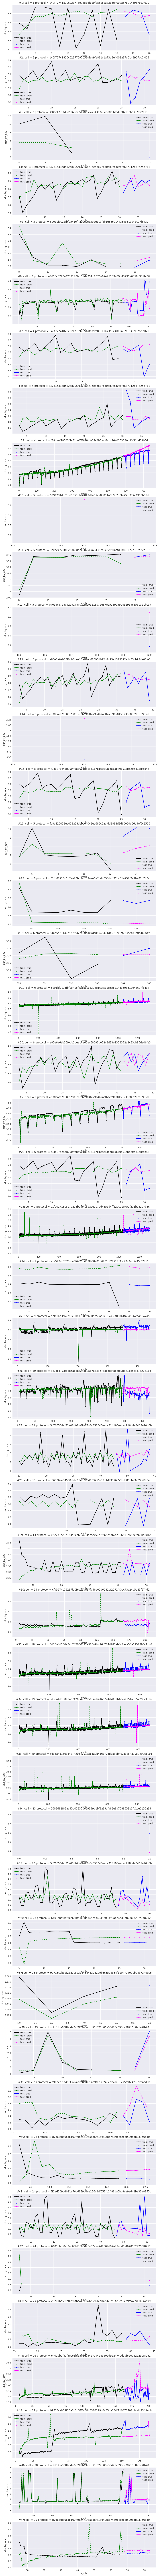

In [17]:
dur_by_ocv_final_df_pd, coefficient, intercept, r2, rmse, smape =  model_performance_with_plots(trainDF = dur_by_ocv_train_DF_feat_vect , testDF = dur_by_ocv_test_DF_feat_vect, labelCol = 'dur_by_ocv', featuresCol='features', regParam= (0.8326/(2*8288)))

In [18]:
print ("The coefficients of the model are : %a" %coefficient, '\n')
print ("The Intercept of the model is : %f" %intercept, '\n')
print("r2: %.3f" %r2, '\n')
print("RMSE: %.3f" %rmse, '\n')
print('sMAPE: %f' %smape, '\n')

The coefficients of the model are : DenseVector([0.0001, -0.0751, -0.0437, -0.118, -0.1265, 0.5325, 1.3474, 1.3625, 0.4208, 0.6563, 0.8297, 0.5857, 0.5841, 0.5145, 0.1562, 0.1171, 0.1659, 0.2558, 0.4107, 0.0643, 2.1399, 3.8307, 0.5657, -0.2112, -0.995, 1.4451, -0.2147, 0.0068, 0.0165, -0.4978, 0.0688, -1.5247, 0.3027, -0.4813, 0.0007, -0.0, -0.1487, -0.1071, 0.0, -0.0007, -1.7111, 0.0, -0.0, -0.5267, 3.0192, 0.0068, -1.2135, 0.3858, -1.3743, 1.0515, -0.0712, 0.2797, -1.4662, -0.0, 0.2833, 0.6092, -0.0352, -0.6099, 1.9967, -0.3194, -0.0997, -0.6598, -0.4036, -0.0]) 

The Intercept of the model is : -23.178352 

r2: 0.924 

RMSE: 0.341 

sMAPE: 5.185047